# Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

Датасет недвижимости (sklearn.datasets.fetch_california_housing или  https://www.kaggle.com/c/avito-demand-prediction)

Задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости на основании числовых данных. Можно сделать генерацию новых признаков. Сеть может включать BatchNorm слои и Dropout
4. Сравнить сходимость Adam, RMSProp и SGD

In [360]:
#!pip install torchmetrics

In [500]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from torchmetrics.regression import R2Score, MeanSquaredError
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,7

In [501]:
X,y = fetch_california_housing(return_X_y=True)

In [502]:
X,y

(array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]))

In [503]:
X.shape

(20640, 8)

In [504]:
scaler = StandardScaler()

In [505]:
#нормализация данных
X = scaler.fit_transform(X)

In [506]:
X

array([[ 2.34476576,  0.98214266,  0.62855945, ..., -0.04959654,
         1.05254828, -1.32783522],
       [ 2.33223796, -0.60701891,  0.32704136, ..., -0.09251223,
         1.04318455, -1.32284391],
       [ 1.7826994 ,  1.85618152,  1.15562047, ..., -0.02584253,
         1.03850269, -1.33282653],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ..., -0.0717345 ,
         1.77823747, -0.8237132 ],
       [-1.05458292, -0.84539315, -0.04021111, ..., -0.09122515,
         1.77823747, -0.87362627],
       [-0.78012947, -1.00430931, -0.07044252, ..., -0.04368215,
         1.75014627, -0.83369581]])

In [507]:
class MyDataset(torch.utils.data.Dataset):
  
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [508]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 13, test_size = 0.25)

In [509]:
X_train.shape, y_train.shape

((15480, 8), (15480,))

In [510]:
X_test.shape, y_test.shape

((5160, 8), (5160,))

In [511]:
train_dataset = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

In [512]:
test_dataset = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

In [513]:
train_dataset[0]

(tensor([-0.1860,  0.5849, -0.3561, -0.0049, -0.0605, -0.0968, -0.6657,  0.6687]),
 tensor(2.6800))

In [514]:
test_dataset[0]

(tensor([ 0.1485, -1.0838,  0.3089, -0.2306, -0.5806,  0.0150, -0.1366,  0.2444]),
 tensor(1.3010))

In [515]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError


class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, hidden_dim, 'leaky_relu')
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "leaky_relu")

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [516]:
r2score = R2Score()
mse = MeanSquaredError()

Рассмотрим разные варианты параметров для подбора оптимальных для нашей модели

## Adam

In [517]:
net = FeedForward(X.shape[1], 128)

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [518]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(8), labels.view(8))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/121]. Loss: 0.044.
mse_test: 1.3822555541992188
Epoch [2/10]. Step [1/121]. Loss: 0.013.
mse_test: 1.3538236618041992
Epoch [3/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.35209321975708
Epoch [4/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.374081015586853
Epoch [5/10]. Step [1/121]. Loss: 0.008.
mse_test: 1.3513612747192383
Epoch [6/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.3592277765274048
Epoch [7/10]. Step [1/121]. Loss: 0.009.
mse_test: 1.3537423610687256
Epoch [8/10]. Step [1/121]. Loss: 0.013.
mse_test: 1.352441430091858
Epoch [9/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3529300689697266
Epoch [10/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3504105806350708
Training is finished!


In [519]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 1.3501918315887451, r2_test: 0.0008302927017211914


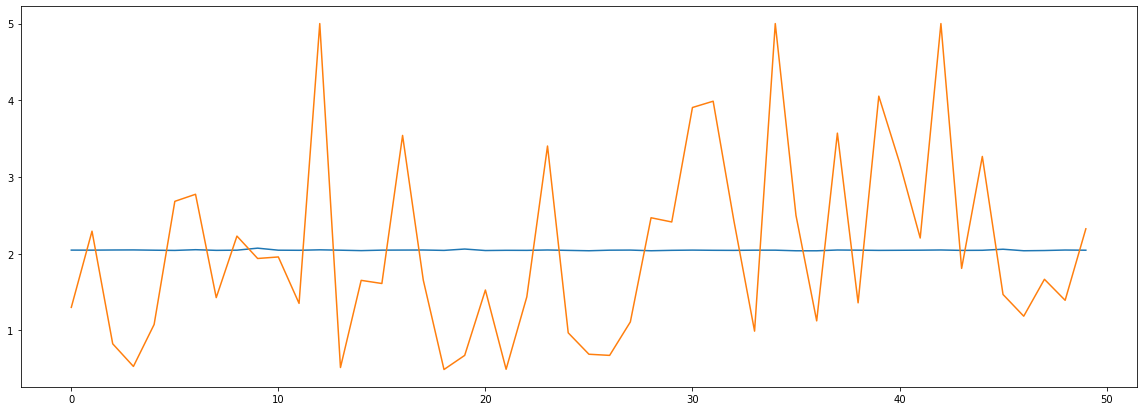

In [520]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

## SGD momentum 0.5

In [521]:
net = FeedForward(X.shape[1], 128)

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.5)
criterion = nn.MSELoss()

In [522]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(8), labels.view(8))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/121]. Loss: 0.041.
mse_test: 1.9925099611282349
Epoch [2/10]. Step [1/121]. Loss: 0.016.
mse_test: 1.3769652843475342
Epoch [3/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.378642201423645
Epoch [4/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.347215175628662
Epoch [5/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.3719942569732666
Epoch [6/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3316601514816284
Epoch [7/10]. Step [1/121]. Loss: 0.009.
mse_test: 1.3956410884857178
Epoch [8/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3668891191482544
Epoch [9/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3314714431762695
Epoch [10/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.3586183786392212
Training is finished!


In [523]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 1.3596597909927368, r2_test: -0.0061762332916259766


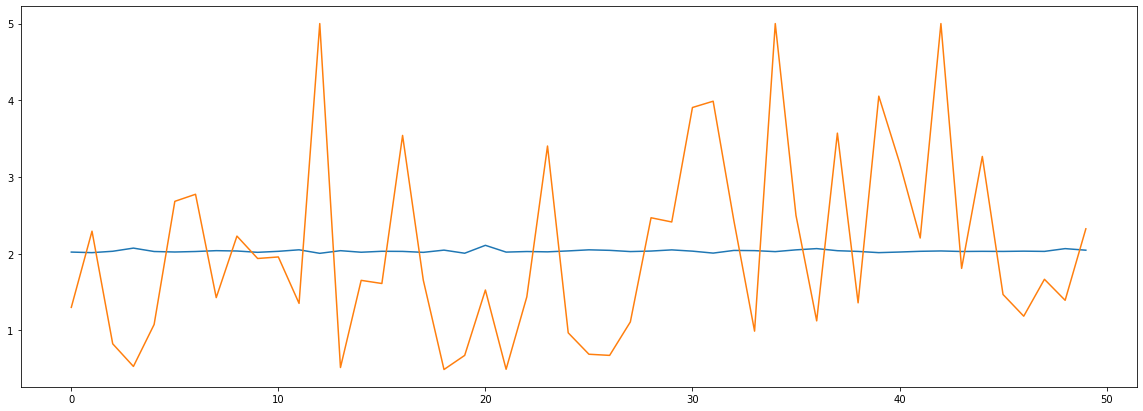

In [524]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

## Adagrad

In [525]:
net = FeedForward(X.shape[1], 128)
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [526]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(8), labels.view(8))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/121]. Loss: 0.032.
mse_test: 1.3830097913742065
Epoch [2/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3556203842163086
Epoch [3/10]. Step [1/121]. Loss: 0.008.
mse_test: 1.3641518354415894
Epoch [4/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3525737524032593
Epoch [5/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.352070927619934
Epoch [6/10]. Step [1/121]. Loss: 0.012.
mse_test: 1.354022741317749
Epoch [7/10]. Step [1/121]. Loss: 0.010.
mse_test: 1.352150559425354
Epoch [8/10]. Step [1/121]. Loss: 0.011.
mse_test: 1.3547390699386597
Epoch [9/10]. Step [1/121]. Loss: 0.012.
mse_test: 1.3570480346679688
Epoch [10/10]. Step [1/121]. Loss: 0.012.
mse_test: 1.3538060188293457
Training is finished!


In [527]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 1.3540077209472656, r2_test: -0.001993536949157715


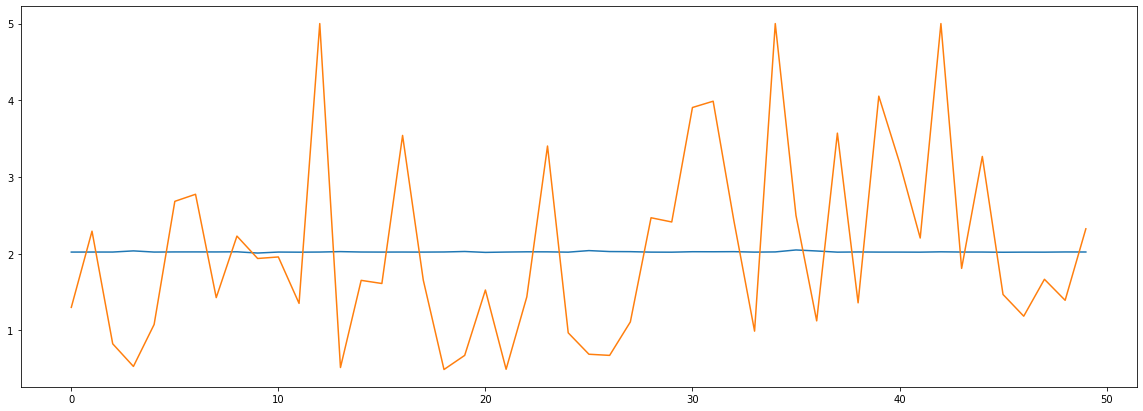

In [528]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

## RMSprop

In [529]:
net = FeedForward(X.shape[1], 128)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.1, alpha=0.99)
criterion = nn.MSELoss()

In [530]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(8), labels.view(8))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/121]. Loss: 0.037.
mse_test: 13.59222412109375
Epoch [2/10]. Step [1/121]. Loss: 0.117.
mse_test: 10.961430549621582
Epoch [3/10]. Step [1/121]. Loss: 0.085.
mse_test: 7.189863204956055
Epoch [4/10]. Step [1/121]. Loss: 0.062.
mse_test: 6.189334869384766
Epoch [5/10]. Step [1/121]. Loss: 0.043.
mse_test: 6.123880863189697
Epoch [6/10]. Step [1/121]. Loss: 0.044.
mse_test: 9.975430488586426
Epoch [7/10]. Step [1/121]. Loss: 0.078.
mse_test: 7.302923679351807
Epoch [8/10]. Step [1/121]. Loss: 0.056.
mse_test: 11.769475936889648
Epoch [9/10]. Step [1/121]. Loss: 0.094.
mse_test: 7.480489730834961
Epoch [10/10]. Step [1/121]. Loss: 0.058.
mse_test: 6.857567310333252
Training is finished!


In [531]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 6.853951454162598, r2_test: -4.0720648765563965


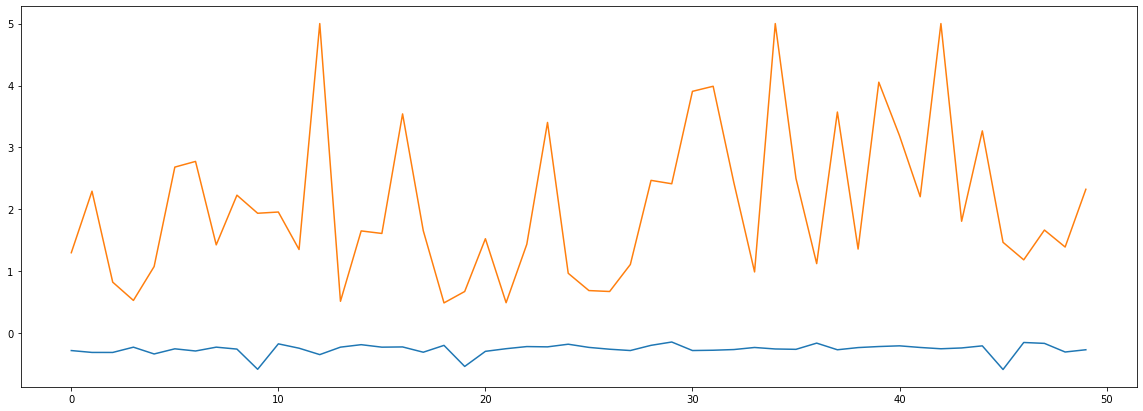

In [532]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

Вывод: лучше всего для данной модели на данном этапе настройки работает оптимизатор adam. Почти с такой же mse работает adagrad и sgd momentum 0.5. Худший результат показал RMSprop.

## Генерация признаков

Попробуем провести генерацию новых признаков и проверим работу модели.

In [533]:
X = pd.DataFrame(X, columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8'])
col_last = 'col1'
for col_1 in X.columns:
    X[str(col_1)+'square'] = X[col_1]**2
    X[str(col_1)+'cube'] = X[col_1]**3
    X[str(col_1)+str(col_last)] = X[col_1]*X[col_last]
    col_last = col_1
    

X = np.array(X)
X

array([[ 2.34476576,  0.98214266,  0.62855945, ...,  1.76314638,
        -2.34116786, -1.39761068],
       [ 2.33223796, -0.60701891,  0.32704136, ...,  1.74991602,
        -2.31486576, -1.37997034],
       [ 1.7826994 ,  1.85618152,  1.15562047, ...,  1.77642656,
        -2.36766844, -1.38414393],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ...,  0.67850343,
        -0.55889223, -1.46475767],
       [-1.05458292, -0.84539315, -0.04021111, ...,  0.76322286,
        -0.66677154, -1.55351496],
       [-0.78012947, -1.00430931, -0.07044252, ...,  0.69504871,
        -0.5794592 , -1.45908962]])

In [534]:
X.shape

(20640, 32)

In [535]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 13, test_size = 0.25)

In [536]:
X_train.shape, X_test.shape

((15480, 32), (5160, 32))

In [537]:
train_dataset = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2, drop_last=True)

In [538]:
test_dataset = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False, drop_last=True)

In [539]:
net = FeedForward(X.shape[1], 128)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [540]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(8), labels.view(8))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10]. Step [1/120]. Loss: 0.039.
mse_test: 5.342510223388672
Epoch [2/10]. Step [1/120]. Loss: 0.045.
mse_test: 4.773069858551025
Epoch [3/10]. Step [1/120]. Loss: 0.038.
mse_test: 4.454787254333496
Epoch [4/10]. Step [1/120]. Loss: 0.033.
mse_test: 3.9368534088134766
Epoch [5/10]. Step [1/120]. Loss: 0.034.
mse_test: 3.6075949668884277
Epoch [6/10]. Step [1/120]. Loss: 0.028.
mse_test: 2.9824233055114746
Epoch [7/10]. Step [1/120]. Loss: 0.018.
mse_test: 2.666971445083618
Epoch [8/10]. Step [1/120]. Loss: 0.025.
mse_test: 2.4369349479675293
Epoch [9/10]. Step [1/120]. Loss: 0.014.
mse_test: 2.0138535499572754
Epoch [10/10]. Step [1/120]. Loss: 0.015.
mse_test: 2.1215121746063232
Training is finished!


In [541]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 1.8015806674957275, r2_test: -0.33320677280426025


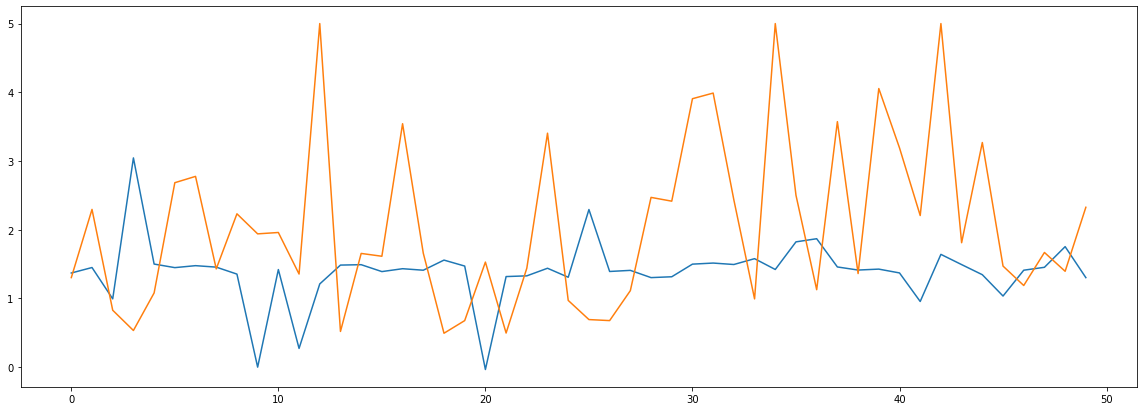

In [542]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

Вывод: генерация дополнительных признаков изменила обучаемость модели, она пытается сформировать зависимости. Но необходимо еще подбирать оптимальные параметры.

## Изменение параметров сети - изменение количества эпох, batch size, параметров оптимизатора, количества слоев и количества нейронов в слое

In [545]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError


class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, 2*hidden_dim, 'relu')
        self.bn1 = nn.BatchNorm1d(2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim, "relu")
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.fc3 = Perceptron(hidden_dim, 1, "relu")

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        return x

In [546]:
train_dataset = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=1000,
                          shuffle=True,
                          num_workers=2, drop_last=True)

In [547]:
test_dataset = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20,
                                          shuffle=False, drop_last=True)

In [560]:
net = FeedForward(X.shape[1], 2048)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [561]:
num_epochs = 15

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)


        # выводим статистику о процессе обучения
       
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}.')
            running_loss, running_items = 0.0, 0.0
            net.train()
    net.eval()       
    running_mse_test, running_number_test = 0.0, 0.0   
    for i, data in enumerate(test_loader):
        running_number_test += 1
        inputs, labels = data[0], data[1]
        test_outputs = net(inputs)
        mse_test = mse(test_outputs.view(20), labels.view(20))
        running_mse_test+= mse_test
    print(f'mse_test: {running_mse_test/running_number_test}')
    net.train()
     
print('Training is finished!')

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15]. Step [1/15]. Loss: 0.005.
mse_test: 2.325181245803833
Epoch [2/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.6281613111495972
Epoch [3/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.4490838050842285
Epoch [4/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.3674023151397705
Epoch [5/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.4387623071670532
Epoch [6/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3538339138031006
Epoch [7/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.3697021007537842
Epoch [8/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3989638090133667
Epoch [9/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3524470329284668
Epoch [10/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.304431438446045
Epoch [11/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3863062858581543
Epoch [12/15]. Step [1/15]. Loss: 0.002.
mse_test: 1.3629331588745117
Epoch [13/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3542989492416382
Epoch [14/15]. Step [1/15]. Loss: 0.001.
mse_test: 1.3658241033554077
Epoch [15/15]. Step [1/15]. Los

In [562]:
y_pred_test_all = net(torch.Tensor(X_test))
y_pred_test_all
print(f'mse_test : {mse(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}, r2_test: {r2score(y_pred_test_all, torch.Tensor(y_test).view(5160,1))}')

mse_test : 1.5000687837600708, r2_test: -0.11008179187774658


Вывод: при различных изменениях параметров mse на тестовых данных остается минимально 1.35.

In [563]:
y_pred_test_all = y_pred_test_all.view(5160).detach().numpy()
y_pred_test_all

array([1.9816006, 1.9592807, 1.9798775, ..., 1.9742327, 1.927466 ,
       2.021328 ], dtype=float32)

In [564]:
y_test

array([1.301, 2.294, 0.826, ..., 3.252, 0.649, 0.455])

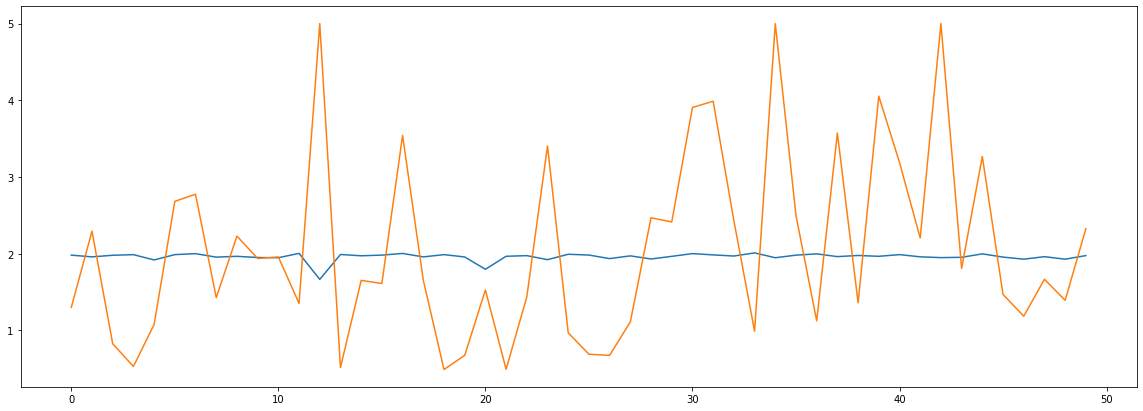

In [565]:
plt.plot(y_pred_test_all[:50])
plt.plot(y_test[:50])

Вывод: необходим дальнейший подбор параметров и количества слоев нейронной сети. Пока функция потерь в процессе обучения оказывается в локальном минимуме и обучение далее двигается с большим трудом.